In [1]:
## call the main routines
using NBInclude
@nbinclude("core_fun.ipynb");

In [2]:
###############################################################
#### Parameters
###############################################################
lambda_function(q) = 1/quadgk(x-> UIpolicy_quebec(x) * q * exp(-q*x), 0, Inf)[1] 

quebec = let 
    
    reform = 1
    A = 30.  *12 
    Amin = 25. *12
    Amax = 40. *12
    
    r = 0.0048 # 5 % annual interest rate, time unit = month
    c0 = 1. # scale parameter of the cost function, normalized to 1

    ### estimated
    alpha, m, q = 0.5400915287867508,  0.14905684129413932,   0.05045705920101544
    lambdamin = lambda_function(q)
    lambdamax = lambda_function(q)  
    
    uinit = [0.32,0.] ## start with 68% employment rate, 32% without UI
    
    wbar = 1
    b0max = 507 * 12/13924 # 507 and 13924 (average earnings) in 1989 (current dollars), from LM2008
    b0min = 185 * 12/13924 # 185 from LM2008
    bUI = 0.6 ## from Canadian statistics
    
    Country(reform,A,Amin,Amax,r,c0,alpha,q,m,lambdamin,lambdamax,uinit,bUI,b0max,b0min,wbar)
end

Country(1, 360.0, 300.0, 480.0, 0.0048, 1.0, 0.5400915287867508, 0.05045705920101544, 0.14905684129413932, 0.10985501075375209, 0.10985501075375209, [0.32, 0.0], 0.6, 0.4369434070669348, 0.15943694340706693, 1.0, 0.0006925527392941526, 0.013248908604437622)

# 1) Finding the parameters
We take as moments the employment rates from age 27 to 32.

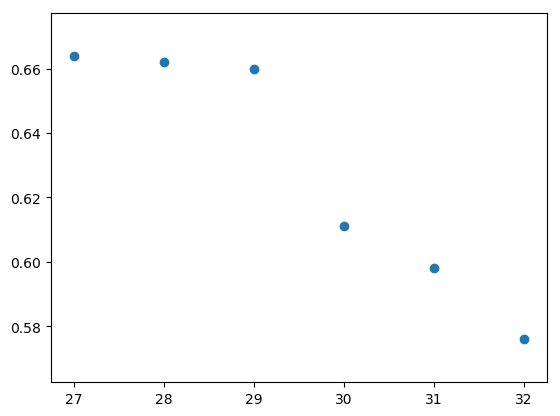

distance (generic function with 1 method)

In [3]:
function moments_quebec(unemp, simu::Simu,C::Country)
    Y27 = quadgk(x->1-sum(unemp(x)[:]) ,27*12,27*12+12)[1]/12
    Y28 = quadgk(x->1-sum(unemp(x)[:]) ,28*12,28*12+12)[1]/12
    Y29 = quadgk(x->1-sum(unemp(x)[:]) ,29*12,29*12+12)[1]/12
    Y30 = quadgk(x->1-sum(unemp(x)[:]) ,30*12,30*12+12)[1]/12
    Y31 = quadgk(x->1-sum(unemp(x)[:]) ,31*12,31*12+12)[1]/12
    Y32 = quadgk(x->1-sum(unemp(x)[:]) ,32*12,32*12+12)[1]/12
    return( [Y27, Y28, Y29, Y30, Y31, Y32])
end

moments_target = let
    mom0 = 0.19
    Y27,Y28, Y29, Y30, Y31, Y32 = 0.664, 0.662, 0.660, 0.611, 0.598, 0.576
    scatter(27:32,[Y27,Y28, Y29, Y30, Y31, Y32])
    [Y27, Y28, Y29, Y30, Y31, Y32]
end

function distance(m1,m2)
    out = 0
    for i in 1:length(m1)
        out += (m1[i] - m2[i]) ^2
    end
    return(out)
end

In [4]:
function objective_qb(alpha,m,q,C::Country)
    ## modify C
    newC = Country(C.reform,C.A,C.Amin,C.Amax,C.r,C.c0,
        alpha, q, m,lambda_function(q),lambda_function(q),
        C.uinit,C.bUI,C.b0max,C.b0min,C.wbar)
    
    ## simulate
    simu = find_simu(newC,reltol=1e-8)
    unemp = find_unemp(simu, newC, unitSS = false) 
    v1 = moments_quebec(unemp,simu,newC)
    
    IJulia.clear_output(true)
    println(alpha," ",m)
    println(v1)
    
    distance(v1, moments_target) 
end

function find_quebec(q,C::Country)
    opt = Opt(:LN_BOBYQA, 2)
    lower_bounds!(opt, [0.1 , 0.])
    upper_bounds!(opt, [5. , 1.])
    #xtol_rel!(opt,1e-12)
    stopval!(opt,1e-15)
    min_objective!(opt, (v,g)-> objective_qb(v[1],v[2],q,C))
    
    init =  [0.5, 0.2 ] 
    
    (minf,minx,ret) = optimize(opt, init) 
    println("Param found with convergence ", ret, ", the value of the objective is ",minf)
    println(minx[1], "  ",minx[2])
    return(minx)
end

q_vec = [0.005, 0.01, 0.025, 0.05, 0.1]
am_vec = zeros(2,5)
for (i,q) in enumerate(q_vec)
    am_vec[:,i] =  find_quebec(q,quebec)
end
am_vec

0.4395672016715562 0.29203881755639116
[0.666201, 0.666051, 0.654074, 0.600569, 0.592045, 0.59197]
Param found with convergence ROUNDOFF_LIMITED, the value of the objective is 0.00045570315938251853
0.4395672016715562  0.29203881755639116


2×5 Array{Float64,2}:
 0.132954   0.297961   0.526394   0.540929  0.439567
 0.0163111  0.0292509  0.0735611  0.147713  0.292039

# 2)Moments

In [5]:
lam_vec = zeros(length(q_vec))
jfr0bef_vec = zeros(length(q_vec))
jfr0aft_vec = zeros(length(q_vec))
mom_vec = zeros(length(moments_target),length(q_vec))

for (i,q) in enumerate(q_vec)
    alpha, m, q = am_vec[1,i], am_vec[2,i], q_vec[i]
    lambda = lambda_function(q)
    lam_vec[i] = lambda
    
    newC = Country(quebec.reform,quebec.A,quebec.Amin,quebec.Amax,quebec.r,quebec.c0,
        alpha, q, m,lambda,lambda,
        quebec.uinit,quebec.bUI,quebec.b0max,quebec.b0min,quebec.wbar)
    simu_qb = find_simu(newC,reltol=1e-5)
    jfr0bef_vec[i] = JFrate(simu_qb.Xbar1(27*12),newC)
    jfr0aft_vec[i] = JFrate(simu_qb.Xbar1(newC.A),newC)
    
    unemp_qb = find_unemp(simu_qb, newC, unitSS = false) 
    mom_vec[:,i] = moments_quebec(unemp_qb,simu_qb,newC)
end

mid_vec = vcat(mom_vec .*100 ,lam_vec',jfr0bef_vec',jfr0aft_vec')

9×5 Array{Float64,2}:
 67.4775      67.5021     67.3829     67.009      66.6201  
 66.0925      66.2165     66.4205     66.6533     66.605   
 64.1698      64.2324     64.3869     64.8292     65.4074  
 61.9147      61.7397     61.2609     60.6812     60.0569  
 59.7782      59.6196     59.3283     59.1228     59.2045  
 57.8445      57.9786     58.4082     58.8232     59.197   
  0.0887277    0.0908376   0.097472    0.109619    0.138626
  0.00898485   0.0205393   0.0568305   0.125195    0.293905
  0.00327801   0.0111732   0.0354114   0.0780627   0.173696

# 3) Simulated coefficients

In [6]:
coef_vec = zeros(length(q_vec))
late_vec = zeros(length(q_vec))

age_grid = 25:39
for (i,q) in enumerate(q_vec)
    alpha, m, q = am_vec[1,i], am_vec[2,i], q_vec[i]
    lambda = lambda_function(q)
    newC = Country(quebec.reform,quebec.A,quebec.Amin,quebec.Amax,quebec.r,quebec.c0,
        alpha, q, m,lambda,lambda,
        quebec.uinit,quebec.bUI,quebec.b0max,quebec.b0min,quebec.wbar)
    simu_qb = find_simu(newC,reltol=1e-5)
    unemp_qb = find_unemp(simu_qb, newC, unitSS = false) 



    Y = [quadgk(x->1-sum(unemp_qb(x)[:]) ,m,m+12)[1]/12 for m in 12*age_grid] 

    # linear spline
    TREAT = [a>=quebec.A for a in age_grid*12]
    consta = ones(size(age_grid))
    age1 = collect(age_grid*12)
    age2 = age1 .^2
    age3 = age1 .^3
    age1_spl = (age1 .- quebec.A) .* TREAT 
    X = hcat(TREAT, consta, age1, age1_spl)
    beta = inv(X' * X) * (X' * Y)
    coef_vec[i] = beta[1]

    unemp_qb_counter0 = find_unemp_counter0(simu_qb, newC, unitSS = false) 
    unemp_qb_counter1 = find_unemp_counter1(simu_qb, newC, unitSS = false) 

    emp_after = 1-sum(unemp_qb_counter1(newC.A)[:])
    emp_before = 1-sum(unemp_qb_counter0(newC.A)[:])
    late_vec[i] = emp_after-emp_before
end

late_vec

5-element Array{Float64,1}:
 -0.1947103372216008 
 -0.13567970885223823
 -0.09709254327884276
 -0.08195006744502464
 -0.0742185866599977 

# The final table is

In [7]:
vcat(q_vec',am_vec,mid_vec,-0.049 .* ones(length(q_vec))',coef_vec',late_vec')

15×5 Array{Float64,2}:
  0.005        0.01        0.025       0.05        0.1      
  0.132954     0.297961    0.526394    0.540929    0.439567 
  0.0163111    0.0292509   0.0735611   0.147713    0.292039 
 67.4775      67.5021     67.3829     67.009      66.6201   
 66.0925      66.2165     66.4205     66.6533     66.605    
 64.1698      64.2324     64.3869     64.8292     65.4074   
 61.9147      61.7397     61.2609     60.6812     60.0569   
 59.7782      59.6196     59.3283     59.1228     59.2045   
 57.8445      57.9786     58.4082     58.8232     59.197    
  0.0887277    0.0908376   0.097472    0.109619    0.138626 
  0.00898485   0.0205393   0.0568305   0.125195    0.293905 
  0.00327801   0.0111732   0.0354114   0.0780627   0.173696 
 -0.049       -0.049      -0.049      -0.049      -0.049    
 -0.0276738   -0.0369962  -0.0441563  -0.048435   -0.0526443
 -0.19471     -0.13568    -0.0970925  -0.0819501  -0.0742186